# 0. 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter
from kiwipiepy import Kiwi
kiwi=Kiwi()
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# 1. 데이터 확인

In [2]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
common_data_path ="~/aiffel/aiffel/dlthon/common_conversations(1000).csv"
common_data = pd.read_csv(common_data_path)
common_data.head()

,text,label
0,보고싶더랴.. 오라고는 못하겠고\n아이고..담주에 가야겠네\n가끔 가면 좋아하시는데...,일반 대화
1,아니 나 다음주까지 완결치는게 목표인데 의자 안옵니까?ㅠㅠ\nㅠㅠㅠㅠㅠㅠ 개빡쳐 진...,일반 대화
2,맞아 현실적인 조언이군\n근데 난 오히려 저런 현실적인 조언이 조아\nㅋㅋㄱㅋ#@기...,일반 대화
3,나 엘레베이터안인데 애기가 나 발로 차서\n어엉 ㅇㅁㅇ 왜차!\n걍 안쳐다보고 그러...,일반 대화
4,#@기타#데이에 다들 시다 뛸 준비하고와\n#@이름#시켜 #@이름#가 모형다만들엇어...,일반 대화


In [4]:
common_data.rename(columns={'text': 'conversation', 'label': 'class'}, inplace=True)
train_data = pd.concat([train_data, common_data], ignore_index=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,idx,class,conversation
0,2590.0,갈취 대화,이 사장님 이거 오랜만입니다?\n아.자네 어쩐 일인가.\n어쩐 일이냐뇨 섭섭하네요....
1,3819.0,직장 내 괴롭힘 대화,자네는 지금 나랑 같이 일을 하고 싶은 건가? 일을 이딴식으로 밖에 못해?!?!\n...
2,NaN,일반 대화,뇽뇽\n근데 자소서 너무ㅜ 어렵당\n아구 자소서 이놈들!!\n재미없더!\n으앙 누구...
3,3193.0,협박 대화,야! 너네 또 뛰었지!!!\n저희 집이 뛴 거 아니라구요\n너네잖아!!!!\n저희 ...
4,3484.0,직장 내 괴롭힘 대화,새론씨 지금 창고 좀 와봐요\n 네. 무슨일 있으세요?\n아 별건 아니고 새론씨 망...


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   idx           3950 non-null   float64
 1   class         4950 non-null   object 
 2   conversation  4950 non-null   object 
dtypes: float64(1), object(2)
memory usage: 116.1+ KB
None


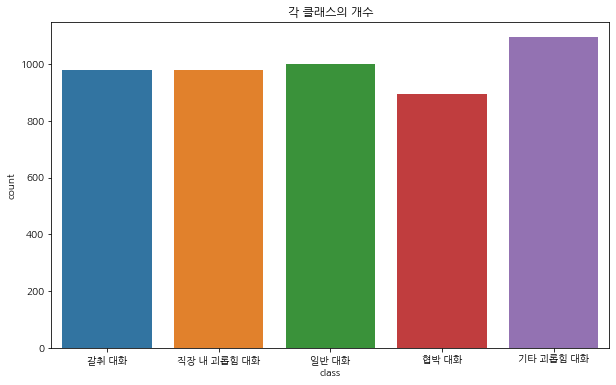

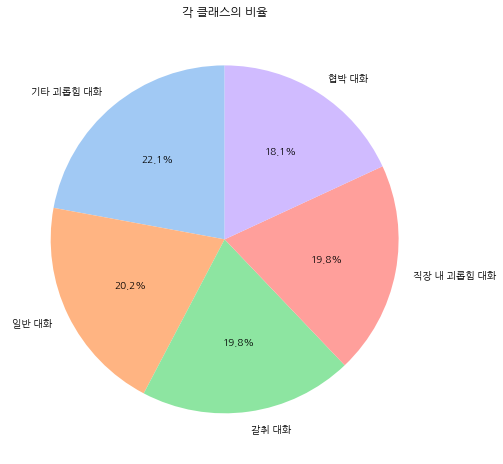

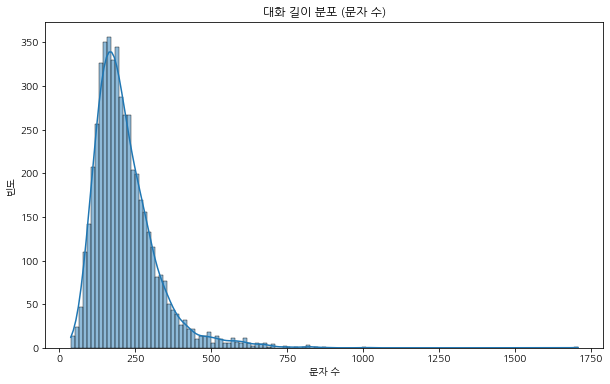

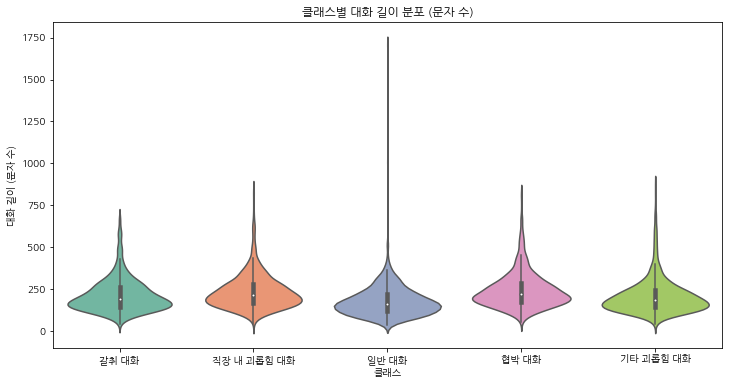

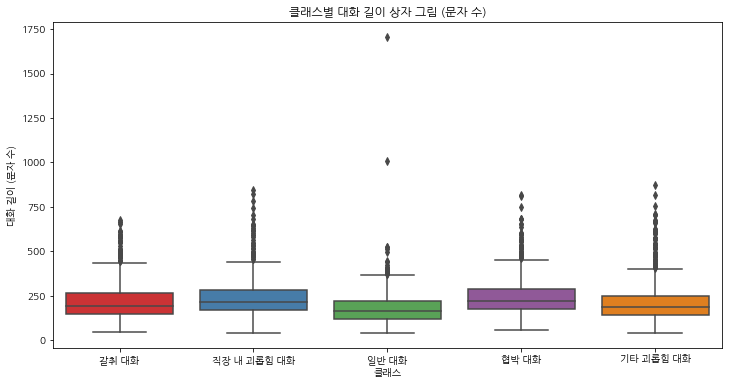

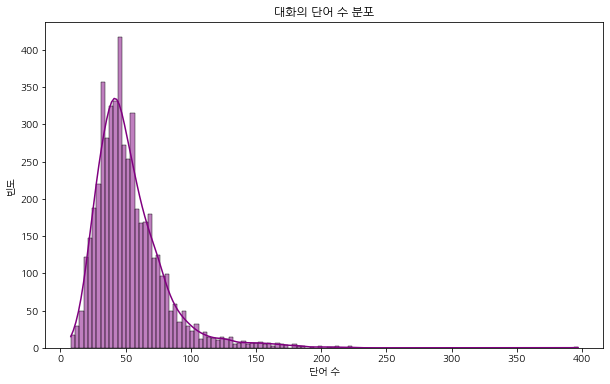

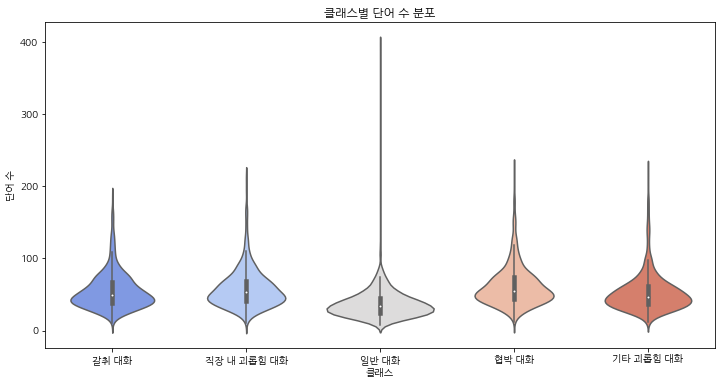

In [5]:
# 한글 폰트 설정 (여기서는 'NanumGothic' 폰트를 사용)
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 기본 정보 확인
print("Train Data Info:")
print(train_data.info())  # 데이터 타입, 결측치 확인

# 1. 'class' 컬럼의 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('각 클래스의 개수')
plt.show()

# 2. 'class' 컬럼의 비율을 Pie Chart로 시각화
plt.figure(figsize=(8, 8))
train_data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('각 클래스의 비율')
plt.ylabel('')  # Y-label 제거
plt.show()

# 3. 'conversation' 텍스트의 길이 분포 확인 (각 문장의 문자 수)
train_data['text_length'] = train_data['conversation'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], kde=True)
plt.title('대화 길이 분포 (문자 수)')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.show()

# 4. 'class'별로 'conversation' 길이 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='text_length', data=train_data, palette='Set2')
plt.title('클래스별 대화 길이 분포 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 5. 'class'별로 'conversation' 길이 상자 그림(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=train_data, palette='Set1')
plt.title('클래스별 대화 길이 상자 그림 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 6. 'class'별로 대화 내용의 단어 수 분포 확인
train_data['word_count'] = train_data['conversation'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], kde=True, color='purple')
plt.title('대화의 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

# 7. 'class'별로 단어 수 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='word_count', data=train_data, palette='coolwarm')
plt.title('클래스별 단어 수 분포')
plt.xlabel('클래스')
plt.ylabel('단어 수')
plt.show()

In [6]:
train_data.isnull().sum()

idx             1000
class              0
conversation       0
text_length        0
word_count         0
dtype: int64

# 2. 전처리

라벨 인코딩

In [7]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
train_data.head()

,idx,class,conversation,text_length,word_count
0,2590.0,0,이 사장님 이거 오랜만입니다?\n아.자네 어쩐 일인가.\n어쩐 일이냐뇨 섭섭하네요....,309,74
1,3819.0,3,자네는 지금 나랑 같이 일을 하고 싶은 건가? 일을 이딴식으로 밖에 못해?!?!\n...,294,76
2,NaN,2,뇽뇽\n근데 자소서 너무ㅜ 어렵당\n아구 자소서 이놈들!!\n재미없더!\n으앙 누구...,160,29
3,3193.0,4,야! 너네 또 뛰었지!!!\n저희 집이 뛴 거 아니라구요\n너네잖아!!!!\n저희 ...,208,50
4,3484.0,3,새론씨 지금 창고 좀 와봐요\n 네. 무슨일 있으세요?\n아 별건 아니고 새론씨 망...,220,58


kiwipiepy 형태소 분석기

In [8]:
!pip install kiwipiepy

In [9]:
# 데이터 정제 함수
def preprocess_sentence(sentence):

    # 앞뒤 공백 제거
    sentence = sentence.strip()
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 다중 공백을 단일 공백으로
    sentence = re.sub(r"\s+", " ", sentence)
    
    # ㅋㅋ, ㅎㅎ, ㅠㅠ 등을 정규화
    sentence = re.sub(r'ㅋ{2,}', 'ㅋㅋ', sentence)  # 연속된 ㅋ를 ㅋㅋ로 통일
    sentence = re.sub(r'ㅎ{2,}', 'ㅎㅎ', sentence)  # 연속된 ㅎ를 ㅎㅎ로 통일
    sentence = re.sub(r'ㅠ{2,}', 'ㅠㅠ', sentence)  # 연속된 ㅠ를 ㅠㅠ로 통일

    return sentence

In [10]:
# 데이터 정제
clean_data=[]

for x in train_data['conversation']:
    clean_data.append(preprocess_sentence(x))
    
len(clean_data)

4950

In [11]:
# 정제된 데이터 conversation에 저장
train_data['conversation'] = clean_data

단어 사전 정의

In [12]:
# 토큰화 실행 함수
def tokenizer(data):

    tokens = []
    
    # 토큰화
    for sentence in data:

        result = kiwi.tokenize(sentence)

        for x in result:

            tokens.append(x[0])
    
    return tokens
 
# RNN류 단어 사전 정의 함수
def build_vocab(tokens):
    
    # 단어의 빈도수 계산
    word_counts = Counter(tokens)
    num_words = len(word_counts)
    word_counts = word_counts.most_common(num_words + 4)
    
    # 고유한 단어 리스트 만들기
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in word_counts]
    vocab = {word: index for index, word in enumerate(vocab)}
    
    vocab_size = len(vocab)
    
    return vocab, vocab_size

In [13]:
# 토큰화
tokens = tokenizer(train_data['conversation'])

# 단어 사전 생성
vocab, vocab_size = build_vocab(tokens)

print("단어 사전:", vocab)
print("단어 수:", vocab_size)

단어 사전: {'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3, '어': 4, '.': 5, '이': 6, '하': 7, '?': 8, '가': 9, '나': 10, '는': 11, 'ᆫ': 12, '었': 13, '고': 14, '거': 15, '야': 16, '지': 17, 'ᆯ': 18, '너': 19, '!': 20, '주': 21, '도': 22, '에': 23, '말': 24, '네': 25, '안': 26, '아니': 27, '다': 28, '보': 29, '어서': 30, '게': 31, '있': 32, '은': 33, '되': 34, '면': 35, '을': 36, '겠': 37, '없': 38, '시': 39, '저': 40, '어요': 41, '뭐': 42, '알': 43, '아': 44, '왜': 45, '것': 46, '만': 47, 'ᆸ니다': 48, '니': 49, '좀': 50, '오': 51, '그렇': 52, '의': 53, '들': 54, '는데': 55, 'ㅋㅋ': 56, '님': 57, '돈': 58, '요': 59, '습니다': 60, '냐': 61, '일': 62, '세요': 63, '못': 64, 'ᆫ데': 65, '진짜': 66, '같': 67, '어야': 68, '지금': 69, '를': 70, '기': 71, '라고': 72, '죄송하': 73, '로': 74, '그': 75, '잘': 76, '한테': 77, '그러': 78, '우리': 79, '않': 80, '자': 81, '이거': 82, '좋': 83, '으로': 84, '먹': 85, '그냥': 86, '한': 87, '사람': 88, '그거': 89, '무슨': 90, '그럼': 91, '수': 92, '으면': 93, '라': 94, '오늘': 95, '잖아': 96, '싶': 97, '사': 98, '죽': 99, '까지': 100, '내': 101, '에서': 102, '맞': 103, '너무': 104,

정수 인코딩

In [14]:
# 문장 -> 숫자 시퀀스 변환 및 패딩

def sentence_to_sequence(wordlist):
    return [vocab[word] for word in wordlist if word in vocab]

def sequence_padding(data):
    return tf.keras.preprocessing.sequence.pad_sequences(data,
                                                        value=vocab["<PAD>"],
                                                        padding='pre',
                                                        maxlen=MAX_LENGTH)

def tokenize_input(data):
    
    train_conversation = list(map(sentence_to_sequence, data))
    train_conversation = sequence_padding(train_conversation)
    
    return train_conversation

In [15]:
# 숫자 시퀀스 변환로 변환
train_conversation = list(map(sentence_to_sequence, train_data['conversation']))

In [16]:
# 정수 인코딩된 데이터 conversation에 저장
train_data['conversation'] = train_conversation

MAX_LENGTH 이하 샘플링

In [17]:
# max_len 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고
# 포함할 수 있는지 통계로 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 210

In [19]:
# 통계 확인
below_threshold_len(MAX_LENGTH, train_data['conversation'])

전체 샘플 중 길이가 210 이하인 샘플의 비율: 0.8345454545454546


In [20]:
# MAX_LENGTH 이하 샘플링
train_data = train_data[train_data['conversation'].apply(lambda x: len(x) <= MAX_LENGTH)]

print(len(train_data))

4131


MAX_LENGTH로 패딩

In [21]:
train_conversation = sequence_padding(train_data['conversation'])

label(target) -> list

In [22]:
# 리스트화
train_label = np.array(list(train_data['class']))

데이터셋 분리

In [23]:
x_train, x_test, y_train, y_test = train_test_split(train_conversation, train_label, test_size=0.25, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_test lenght :", len(x_test))
print("y_train lenght :", len(y_train))
print("y_test lenght :", len(y_test))

x_train lenght : 3098
x_test lenght : 1033
y_train lenght : 3098
y_test lenght : 1033


In [24]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_val lenght :", len(x_val))
print("y_train lenght :", len(y_train))
print("y_val lenght :", len(y_val))

x_train lenght : 2478
x_val lenght : 620
y_train lenght : 2478
y_val lenght : 620


# 3. 모델링

모델 정의

In [25]:
word_vector_dim = 8  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(4, activation='softmax')) # 4개 카테고리, softmax 사용

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           115408    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          912       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 3

모델 컴파일

In [26]:
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

모델 훈련

In [27]:
epochs=5
history = model_cnn.fit(x_train,
                         y_train,
                         epochs=epochs,
                         batch_size=256,
                         validation_data=(x_val, y_val),
                         verbose=1)

Epoch 1/5
10/10 [==============================] - 35s 63ms/step - loss: nan - accuracy: 0.1957 - val_loss: nan - val_accuracy: 0.2177
Epoch 2/5
10/10 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1921 - val_loss: nan - val_accuracy: 0.2177
Epoch 3/5
10/10 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1921 - val_loss: nan - val_accuracy: 0.2177
Epoch 4/5
10/10 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.1921 - val_loss: nan - val_accuracy: 0.2177
Epoch 5/5
10/10 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.1921 - val_loss: nan - val_accuracy: 0.2177


# 4. 평가

예측

In [28]:
# 예측
y_pred_probs = model_cnn.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # 예측 결과의 확률 중 가장 높은 인덱스를 선택

# F1 점수 계산
f1 = f1_score(y_test, y_pred, average='weighted')  # weighted는 클래스 비율에 따른 가중 평균
print("F1 Score:", f1)

F1 Score: 0.06280968117020716
